# Outline
    preprocessing
        impute base on 2 hour avg
        shift 1 - 12 columns
        feature engineering
    trainning
        model (Nested CV) for each hour, drop specific columns since pm2.5 column with missing value are different for each hour
            Stack
                knn
                rf
                LR
                XGBoost
                SVM

Yes, you can rank the most predictive features without retraining the model, provided your trained model supports feature importance retrieval. Here's how you can do it depending on the type of model you're using:

---

### **1. Tree-Based Models (e.g., Random Forest, XGBoost)**
Tree-based models inherently compute feature importance during training, so you can directly access this information.

#### **Accessing Feature Importance**
```python
# Assuming 'model' is your trained Random Forest or XGBoost model
importances = model.feature_importances_

# Get feature names if available (for pipelines, extract preprocessed features)
feature_names = X_train.columns  # or use the pipeline step output if transformed

# Pair feature names with their importance
feature_importance = list(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Ranked Features by Importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")
```

---

### **2. Logistic Regression**
Logistic regression uses weights (coefficients) to determine the influence of features. You can rank features by the magnitude of their coefficients.

#### **Accessing Feature Coefficients**
```python
# Assuming 'model' is your trained Logistic Regression model
coefficients = model.coef_[0]  # Access the coefficients for the positive class

# Pair feature names with their coefficients
feature_importance = list(zip(feature_names, coefficients))

# Sort features by absolute coefficient value
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
print("Ranked Features by Coefficient Magnitude:")
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient:.4f}")
```

---

### **3. SVM (with Linear Kernel)**
For linear SVMs, you can access the coefficients of the decision boundary, similar to logistic regression.

#### **Accessing Feature Coefficients**
```python
# Assuming 'model' is your trained SVC with a linear kernel
coefficients = model.coef_[0]  # Access the coefficients

# Pair feature names with their coefficients
feature_importance = list(zip(feature_names, coefficients))

# Sort features by absolute coefficient value
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
print("Ranked Features by Coefficient Magnitude:")
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient:.4f}")
```

---

### **4. K-Nearest Neighbors (KNN)**
KNN does not compute feature importance inherently because it is a non-parametric model. However, you can estimate feature importance using techniques like permutation importance or feature contribution analysis.

#### **Permutation Importance**
Permutation importance involves shuffling a feature's values and measuring the impact on model performance.

```python
from sklearn.inspection import permutation_importance

# Assuming 'model' is your trained KNN model
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1)

# Get feature importances
importances = result.importances_mean

# Pair feature names with their importances
feature_importance = list(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Ranked Features by Permutation Importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")
```

---

### **5. Using SHAP (Model-Agnostic Feature Importance)**
**SHAP (SHapley Additive exPlanations)** is a popular method for explaining predictions and analyzing feature importance across any model.

#### **Example with SHAP**
```python
import shap

# Create a SHAP explainer (model-agnostic or model-specific)
explainer = shap.Explainer(model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)
```

---

### **6. Feature Importance in a Pipeline**
If you are using a pipeline, ensure you extract the feature names after preprocessing to match the transformed data.

#### **Extracting Feature Names from a Pipeline**
```python
# Get the preprocessor step
preprocessor = pipeline.named_steps['preprocessor']

# Retrieve feature names after preprocessing
feature_names = preprocessor.transformers_[0][2]  # Adjust index based on transformers

# Access feature importance as shown earlier for your model
```

---

### **Conclusion**
- **Tree-based models** and **linear models** provide direct access to feature importance through attributes like `.feature_importances_` or `.coef_`.
- **Non-parametric models (e.g., KNN)** require additional techniques like permutation importance or SHAP.
- You can extract and rank feature importance directly from the trained model, avoiding retraining.

If you'd like, I can help implement this based on your specific model or data!

In [191]:
import pandas as pd

file_path = 'data/data.csv'
data = pd.read_csv(file_path, index_col=0)

## data visuallization

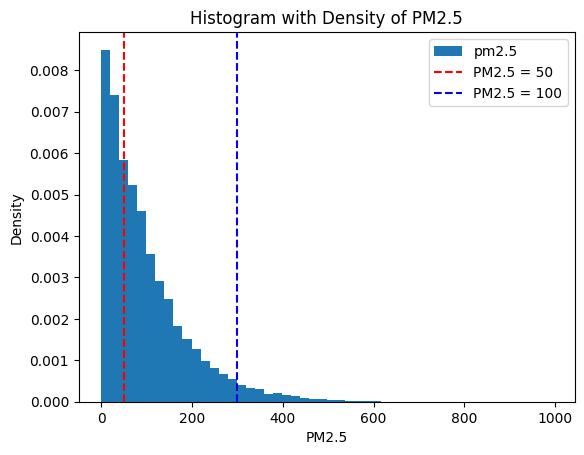

In [192]:
import matplotlib.pyplot as plt

# Adjusted the number of bins to be finer (thinner) by increasing the number
data['pm2.5'].plot(kind='hist', bins=50, density=True, title='Histogram with Density of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Density')
plt.axvline(x=50, color='r', linestyle='--', label='PM2.5 = 50')
plt.axvline(x=300, color='b', linestyle='--', label='PM2.5 = 100')
plt.legend()
plt.show()

In [193]:
# Calculate the percentage of pm2.5 values greater than or equal to 50
pm25_gte_50 = (data['pm2.5'] >= 50).mean() * 100
print(f"Percentage of PM2.5 values >= 50: {pm25_gte_50:.2f}%")

# Calculate the percentage of pm2.5 values greater than or equal to 100
pm25_gte_100 = (data['pm2.5'] >= 300).mean() * 100
print(f"Percentage of PM2.5 values >= 300: {pm25_gte_100:.2f}%")

Percentage of PM2.5 values >= 50: 59.49%
Percentage of PM2.5 values >= 300: 4.05%


In [194]:
daily_hour_counts = data.groupby(['year', 'month', 'day']).size()
missing_hours = daily_hour_counts[daily_hour_counts != 24]
missing_hours
# no missing hours

Series([], dtype: int64)

## preprocessing

In [195]:
data['pm2.5'] = data['pm2.5'].interpolate()

In [196]:
# Creating 12 new columns for future PM2.5 levels, 1 hour to 12 hours ahead
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode the 'cbwd' column
data = pd.get_dummies(data, columns=['cbwd'])

In [197]:
# Calculate the total number of rows with any missing values before dropping
missing_rows_before = data.isna().any(axis=1).sum()
print(f'missing rows before: {missing_rows_before}')
# Drop rows where any cell from 'pm2.5' to 'pm2.5_12_hour_after' is missing
data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

missing rows before: 36


In [198]:
# Calculate the index to split the data at 85% for training and 15% for testing
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

# Split the datasplit_index into training and test sets
data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_train:split_index_test]
data_test_stack = data.iloc[split_index_test:]

## training
    Note: the models in the notebook are fitted only once using predetermined hyperparameters from NestedCV, code with NCV are included also as scripts

Missing rows before: 36
Training Data Size: 21894
Test Data Size: 6569

Evaluating model for 1 hour(s) after...
1 hours after: Test F1 Score: 0.95, Test ROC-AUC: 0.98

Evaluating model for 2 hour(s) after...
2 hours after: Test F1 Score: 0.92, Test ROC-AUC: 0.97

Evaluating model for 3 hour(s) after...
3 hours after: Test F1 Score: 0.90, Test ROC-AUC: 0.94

Evaluating model for 4 hour(s) after...
4 hours after: Test F1 Score: 0.88, Test ROC-AUC: 0.91

Evaluating model for 5 hour(s) after...
5 hours after: Test F1 Score: 0.86, Test ROC-AUC: 0.89

Evaluating model for 6 hour(s) after...
6 hours after: Test F1 Score: 0.85, Test ROC-AUC: 0.87

Evaluating model for 7 hour(s) after...
7 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.85

Evaluating model for 8 hour(s) after...
8 hours after: Test F1 Score: 0.83, Test ROC-AUC: 0.83

Evaluating model for 9 hour(s) after...
9 hours after: Test F1 Score: 0.82, Test ROC-AUC: 0.81

Evaluating model for 10 hour(s) after...
10 hours after: Test F1

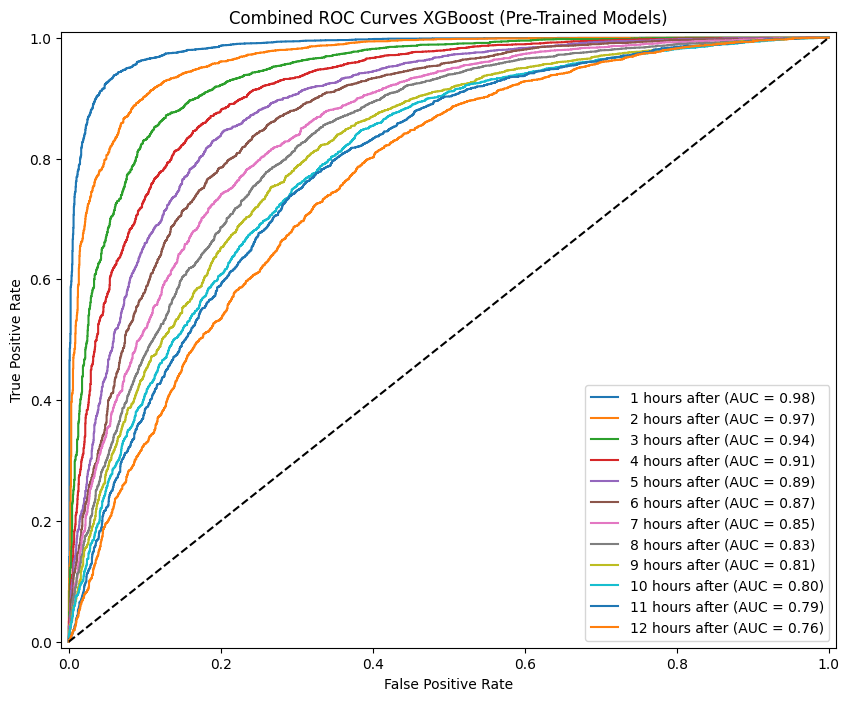

Averaged F1 Score: 0.85
Averaged ROC-AUC: 0.87


In [ ]:
"""XGBoost Classifier Evaluation with Pre-Trained Models
(using previously saved models xgb_hour_{i}.joblib)
"""
#%% Import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

file_path = './data/data.csv'
data = pd.read_csv(file_path, index_col=0)

#%% Preprocessing
data['pm2.5'] = data['pm2.5'].interpolate()

# Creating 12 new columns for future PM2.5 levels, 1 hour to 12 hours ahead
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode the 'cbwd' column
data = pd.get_dummies(data, columns=['cbwd'])

# Calculate the total number of rows with any missing values before dropping
missing_rows_before = data.isna().any(axis=1).sum()
print(f"Missing rows before: {missing_rows_before}")

# Drop rows where any cell from 'pm2.5' to 'pm2.5_12_hour_after' is missing
data.dropna(
    subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)],
    inplace=True
)

# Calculate the index to split the data at 50% for training and 85% for testing
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

# Split the data into training and test sets
data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_test:]

print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

# Prepare training and test data (drop the labels and 'year' columns)
X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# You must ensure that the same preprocessing (scaling, etc.) applied during training is applied here.
# If the saved model is just the classifier, you must reapply the exact preprocessing steps used previously.
# For simplicity, let's assume you used the same pipeline steps and saved the entire pipeline. 
# If not, you need to replicate the preprocessing pipeline code here.

# If you saved only the classifier previously, you must replicate preprocessing:
# Example (if you scaled numerical columns during training):
from sklearn.preprocessing import StandardScaler
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

# Fit the scaler on X_train to simulate original training conditions
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

# Reconstruct X_train and X_test with scaled numerical columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns, index=X_test.index)

# Replace numerical columns in original X_test with scaled versions
X_test_final = X_test.copy()
X_test_final[numerical_columns] = X_test_scaled_df[numerical_columns]

# Initialize lists to store results
f1_scores = []
roc_aucs = []
predictions = {}

num_hours = 12

# Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

for i in range(1, num_hours + 1):
    print(f"\nEvaluating model for {i} hour(s) after...")

    # Define target variables
    y_test = (data_test[f'pm2.5_{i}_hour_after'] >= 50).astype(int)

    # Load the pre-trained model for hour i
    # If you saved only the classifier, here we load the classifier directly
    # If you saved the entire pipeline, you can load the pipeline instead
    # Just replace with: pipeline = joblib.load(f'../outputs/xgb_hour_{i}.joblib')
    # and then do predictions using pipeline.predict/predict_proba
    # For now, we assume we saved only the classifier:
    classifier = joblib.load(f'./outputs/models/xgb_hour_{i}.joblib')

    # Predict on the test data
    y_pred_test = classifier.predict(X_test_final)
    y_prob_test = classifier.predict_proba(X_test_final)[:, 1]

    # Store the predicted values for the current hour
    predictions[f'Hour_{i}_Predictions'] = y_pred_test

    # Calculate test metrics
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store test metrics
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Output test F1 Score and ROC-AUC for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # ROC Curve for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (AUC = {roc_auc_test:.2f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves XGBoost (Pre-Trained Models)')
plt.legend(loc="lower right")

# Save the ROC plot as xgb.png
plt.savefig('./outputs/xgb_stack.png')
plt.show()

print(f"Averaged F1 Score: {np.mean(f1_scores):.2f}")
print(f"Averaged ROC-AUC: {np.mean(roc_aucs):.2f}")

# Save all predictions to a CSV file
prediction_df = pd.DataFrame(predictions)
prediction_df.to_csv('./outputs/xgb_pred_stack.csv', index=False)

# Since we're not doing parameter search here (no best_params calculation),
# we won't save best_params. If needed, you can remove references to best_params
# or load a previously saved best_params file if it exists.

Training Data Size: 21894
Test Data Size: 15325

Evaluating pre-trained model for 1 hour(s) after...
1 hours after: Test F1 Score: 0.95, Test ROC-AUC: 0.98

Evaluating pre-trained model for 2 hour(s) after...
2 hours after: Test F1 Score: 0.92, Test ROC-AUC: 0.96

Evaluating pre-trained model for 3 hour(s) after...
3 hours after: Test F1 Score: 0.90, Test ROC-AUC: 0.93

Evaluating pre-trained model for 4 hour(s) after...
4 hours after: Test F1 Score: 0.89, Test ROC-AUC: 0.91

Evaluating pre-trained model for 5 hour(s) after...
5 hours after: Test F1 Score: 0.87, Test ROC-AUC: 0.89

Evaluating pre-trained model for 6 hour(s) after...
6 hours after: Test F1 Score: 0.86, Test ROC-AUC: 0.88

Evaluating pre-trained model for 7 hour(s) after...
7 hours after: Test F1 Score: 0.85, Test ROC-AUC: 0.86

Evaluating pre-trained model for 8 hour(s) after...
8 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.84

Evaluating pre-trained model for 9 hour(s) after...
9 hours after: Test F1 Score: 0.84,

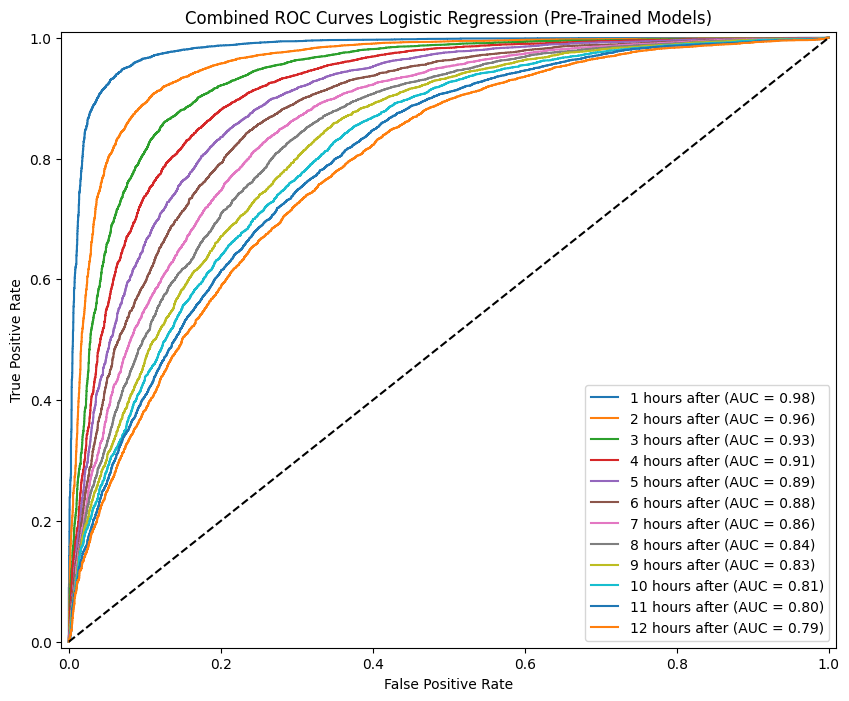

Averaged F1 Score: 0.87
Averaged ROC-AUC: 0.87
Predicted values have been saved to logistic_pretrained_pred.csv


In [227]:
"""
Logistic Regression Classifier Evaluation with Pre-Trained Models (Second-Order Preprocessing)
"""
#%% Import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

# Load the dataset
file_path = './data/data.csv'
data = pd.read_csv(file_path, index_col=0)

# Interpolate missing values in PM2.5
data['pm2.5'] = data['pm2.5'].interpolate()

# Generate future PM2.5 levels (1 to 12 hours ahead)
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode categorical column 'cbwd'
data = pd.get_dummies(data, columns=['cbwd'])

# Remove rows with missing values in PM2.5 predictions
data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

# Split data into training (50%) and testing (15%) sets
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_train:split_index_test]

print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

# Prepare test data
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# Define numerical columns
numerical_columns = X_test.select_dtypes(include=['float64', 'int64']).columns

# Recreate the preprocessing pipeline with PolynomialFeatures
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numerical_columns)
    ],
    remainder='passthrough'
)

# Apply the preprocessing to the test data
X_test_preprocessed = preprocessor.fit_transform(X_test)  # Preprocessing must match the training step

# Initialize lists to store evaluation metrics
f1_scores = []
roc_aucs = []
predictions = {}

num_hours = 12  # Total hours to evaluate

# Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

# Evaluate pre-trained models for each hour
for i in range(1, num_hours + 1):
    print(f"\nEvaluating pre-trained model for {i} hour(s) after...")

    y_test = (data_test[f'pm2.5_{i}_hour_after'] >= 50).astype(int)

    # Load pre-trained model for the current hour
    pipeline = joblib.load(f'./outputs/models/logistic_hour_{i}.joblib')

    # Predict on the preprocessed test data
    y_pred_test = pipeline.predict(X_test_preprocessed)
    y_prob_test = pipeline.predict_proba(X_test_preprocessed)[:, 1]

    # Store predictions
    predictions[f'Hour_{i}_Predictions'] = y_pred_test

    # Calculate metrics
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store evaluation metrics
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Output the metrics for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # Generate ROC curve for the current hour
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (AUC = {roc_auc_test:.2f})')

# Plot a diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves Logistic Regression (Pre-Trained Models)')
plt.legend(loc="lower right")
plt.savefig('./outputs/logistic_stack.png')
plt.show()

# Output averaged metrics
print(f"Averaged F1 Score: {np.mean(f1_scores):.2f}")
print(f"Averaged ROC-AUC: {np.mean(roc_aucs):.2f}")

# Save predictions to CSV
prediction_df = pd.DataFrame(predictions)
prediction_df.to_csv('./outputs/logistic_pred_stack.csv', index=False)
print("Predicted values have been saved to logistic_pretrained_pred.csv")


In [ ]:
"""stacked"""

import pandas as pd

# List of classifiers
classifiers = ['svc', 'rf', 'nn', 'xgb', 'logistic']
predictions = {}

# Load predictions from CSV files
for clf in classifiers:
    predictions[clf] = pd.read_csv(f'./outputs/{clf}_pred.csv')

hourly_predictions = []

for hour in range(1, 13):
    df_hour = pd.DataFrame()
    for clf in classifiers:
        # Get predictions for the current hour
        df_hour[clf] = predictions[clf].loc[:, f'Hour_{hour}_Predictions'].reset_index(drop=True)
    # Add the true label from data_test
    df_hour['True Label'] = data_test[f'pm2.5_{hour}_hour_after'].reset_index(drop=True)
    # Append the DataFrame to the list
    hourly_predictions.append(df_hour)


import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store f1 scores and ROC curve data
f1_scores = []
roc_curves = []
best_params = []  # To store best parameters for each hour

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Iterate over each hour
for hour in range(12):
    print(f"\nProcessing Hour {hour + 1}...")
    
    # Get the dataframe for the current hour
    df_hour = hourly_predictions[hour]
    
    # Define features and label
    X = df_hour.drop(columns=['True Label'])
    y = df_hour['True Label'] >= 50
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
    
    # Initialize the XGBoost model
    model = xgb.XGBClassifier(eval_metric='logloss', random_state=1)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,
        verbose=0
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)
    # print(f"Best parameters for Hour {hour + 1}: {grid_search.best_params_}")
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f'Hour {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Hour')
plt.legend(loc='lower right')
plt.show()

# Print the f1 scores
for i, f1 in enumerate(f1_scores):
    print(f'Hour {i+1}: F1 Score = {f1:.2f}')
